In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.cm as cm
%matplotlib inline
import cmocean
import plotting
from takeout import monthly_means_annual, monthly_std_annual

import copy

In [54]:
# constant declarations
#lat1 < lat2
lat1 = -20
lat2 = 20

lat_lims = [lat1,lat2]

#variable files on disk
omega_file = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/w/w.nc'
omega_file_full = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/mergeFiles/w_7917.nc'


lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

lon_list_small = [80, 100, 120, 140, 160, 180]
lon_list_labels_small = [120., 150., 180., 210., 240., 270.]

shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

yr_ticks = np.arange(1, 468, 12)
p_tick_list = [0, 1, 5, 8, 12, 16, 28]
p_list = [70, 100, 200, 300, 500, 700, 1000]
z_list = [5, 10, 15, 20, 25]

mon_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
mon_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#for plotting
vmin = -0.2
vmax = 0.205
contours = np.arange(vmin, vmax, 0.005)
contours[np.where(np.logical_and(contours>0, contours<5.00000000e-03))]=0

vmin_diff = -0.13
vmax_diff = 0.135
contours_diff = np.arange(vmin_diff, vmax_diff, 0.005)
contours_diff[np.where(np.logical_and(contours_diff>0, contours_diff<5.00000000e-03))]=0


colormap = cmocean.cm.balance
colorbar_label = "$hPa \hspace{1} s^{-1}$"

left_title_diff = '[$-\omega + \omega$]'

#It is actually omega, but weighted for regions where it is upward(or negative) between x˚S and x˚N.
right_title_diff = '1989-2007'
right_title_diff_full = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

figure_name_diff = 'lon_omegaDifference_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'area_weight_avg.pdf'
figure_name_diff_full = 'lon_omegaDifference_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'area_weight_avg_AllYears.pdf'

In [55]:
print(contours)
print(contours_diff)

[-0.2   -0.195 -0.19  -0.185 -0.18  -0.175 -0.17  -0.165 -0.16  -0.155
 -0.15  -0.145 -0.14  -0.135 -0.13  -0.125 -0.12  -0.115 -0.11  -0.105
 -0.1   -0.095 -0.09  -0.085 -0.08  -0.075 -0.07  -0.065 -0.06  -0.055
 -0.05  -0.045 -0.04  -0.035 -0.03  -0.025 -0.02  -0.015 -0.01  -0.005
  0.     0.005  0.01   0.015  0.02   0.025  0.03   0.035  0.04   0.045
  0.05   0.055  0.06   0.065  0.07   0.075  0.08   0.085  0.09   0.095
  0.1    0.105  0.11   0.115  0.12   0.125  0.13   0.135  0.14   0.145
  0.15   0.155  0.16   0.165  0.17   0.175  0.18   0.185  0.19   0.195
  0.2  ]
[-0.13  -0.125 -0.12  -0.115 -0.11  -0.105 -0.1   -0.095 -0.09  -0.085
 -0.08  -0.075 -0.07  -0.065 -0.06  -0.055 -0.05  -0.045 -0.04  -0.035
 -0.03  -0.025 -0.02  -0.015 -0.01  -0.005  0.     0.005  0.01   0.015
  0.02   0.025  0.03   0.035  0.04   0.045  0.05   0.055  0.06   0.065
  0.07   0.075  0.08   0.085  0.09   0.095  0.1    0.105  0.11   0.115
  0.12   0.125  0.13 ]


### Data Import

In [4]:
#read in data files
#omega is in hPa NOT Pa
omega_data = nc.Dataset(omega_file_full)

#process variables
omega = omega_data.variables['w'][:]

lon  = omega_data.variables['longitude'][:]
lat  = omega_data.variables['latitude'][:]
dumb_time = omega_data.variables['time'][:]
#shortened file: levelist, full file: level
p = omega_data.variables['level'][:]

#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = 21

#subset new tensors for correct latitude, pressure ranges
omega_lat = omega[:, :, latidx, :]
omega_lat_p = omega_lat[:, pidx, :, :]

year_list = list(time.year)
count = 0
for yr in np.arange(1979, 2018):
    for i in np.arange(0, 12):
        add = np.round(i / 12.0, 3)
        #print(yr, i, count, add)
        year_list[count] += add
        count += 1

In [5]:
print(np.shape(omega_lat_p))

(468, 27, 240)


### Start Mask Here

### For difference plot, need to:
- up: replace negative values w/ 1, change all positive omegas to NaN: $M^{up}$
- down: replace negative values w/ NaN, change all positive omegas to 1: $M^{down}$
- multiply by cos(lat) matrix to weight omega properly: $M^n*cos\phi$
- nan mean over latitude
- subset for specific pressure level
- plot longitude versus time for up and down masks, both before and after annual cycle is removed

In [6]:
#copy array for creating mask
mask_up = copy.deepcopy(omega_lat_p)
mask_down = copy.deepcopy(omega_lat_p)

#upward mask: M_up
mask_up[np.where(mask_up > 0)] = np.nan
mask_up[np.where(mask_up < 0)] = 1

#downward mask: M_down
mask_down[np.where(mask_down > 0)] = 1
mask_down[np.where(mask_down < 0)] = np.nan

#MX
mask_var_up = np.multiply(omega_lat_p, mask_up)
mask_var_down = np.multiply(omega_lat_p, mask_down)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


In [7]:
#create cos(lat) matrix
cos_lat_ = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((27,240)), cos_lat_)

#MXcos(lat) = AX
mask_var_coslat_up = np.multiply(mask_var_up, cos_lat_matrix)
mask_var_coslat_down = np.multiply(mask_var_down, cos_lat_matrix)

In [8]:
#nan mean over lat (along lon dimension)
mask_var_nanmean_up = np.nanmean(mask_var_coslat_up, axis=1)
mask_var_nanmean_down = np.nanmean(mask_var_coslat_down, axis=1)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#remove mean now?
print(mask_var_nanmean_up.shape)

(468, 240)


In [10]:
#create monthly means for normalization
#monthly_means = monthly_means_annual(omega_lat_p, time)
jan_avg_up = np.nanmean(mask_var_nanmean_up[time.month==1], axis=0)
feb_avg_up = np.nanmean(mask_var_nanmean_up[time.month==2], axis=0)
mar_avg_up = np.nanmean(mask_var_nanmean_up[time.month==3], axis=0)
apr_avg_up = np.nanmean(mask_var_nanmean_up[time.month==4], axis=0)
may_avg_up = np.nanmean(mask_var_nanmean_up[time.month==5], axis=0)
jun_avg_up = np.nanmean(mask_var_nanmean_up[time.month==6], axis=0)
jul_avg_up = np.nanmean(mask_var_nanmean_up[time.month==7], axis=0)
aug_avg_up = np.nanmean(mask_var_nanmean_up[time.month==8], axis=0)
sep_avg_up = np.nanmean(mask_var_nanmean_up[time.month==9], axis=0)
oct_avg_up = np.nanmean(mask_var_nanmean_up[time.month==10], axis=0)
nov_avg_up = np.nanmean(mask_var_nanmean_up[time.month==11], axis=0)
dec_avg_up = np.nanmean(mask_var_nanmean_up[time.month==12], axis=0)
    
monthly_means_up = [jan_avg_up, feb_avg_up, mar_avg_up, apr_avg_up, may_avg_up, jun_avg_up, 
                    jul_avg_up, aug_avg_up, sep_avg_up, oct_avg_up, nov_avg_up, dec_avg_up]

jan_std_up = np.nanstd(mask_var_nanmean_up[time.month==1], axis=0)
feb_std_up = np.nanstd(mask_var_nanmean_up[time.month==2], axis=0)
mar_std_up = np.nanstd(mask_var_nanmean_up[time.month==3], axis=0)
apr_std_up = np.nanstd(mask_var_nanmean_up[time.month==4], axis=0)
may_std_up = np.nanstd(mask_var_nanmean_up[time.month==5], axis=0)
jun_std_up = np.nanstd(mask_var_nanmean_up[time.month==6], axis=0)
jul_std_up = np.nanstd(mask_var_nanmean_up[time.month==7], axis=0)
aug_std_up = np.nanstd(mask_var_nanmean_up[time.month==8], axis=0)
sep_std_up = np.nanstd(mask_var_nanmean_up[time.month==9], axis=0)
oct_std_up = np.nanstd(mask_var_nanmean_up[time.month==10], axis=0)
nov_std_up = np.nanstd(mask_var_nanmean_up[time.month==11], axis=0)
dec_std_up = np.nanstd(mask_var_nanmean_up[time.month==12], axis=0)
    
monthly_stdev_up = [jan_std_up, feb_std_up, mar_std_up, apr_std_up, may_std_up, jun_std_up, 
                    jul_std_up, aug_std_up, sep_std_up, oct_std_up, nov_std_up, dec_std_up]

In [11]:
#create monthly means for normalization
#monthly_means = monthly_means_annual(omega_lat_p, time)
jan_avg_d = np.nanmean(mask_var_nanmean_down[time.month==1], axis=0)
feb_avg_d = np.nanmean(mask_var_nanmean_down[time.month==2], axis=0)
mar_avg_d = np.nanmean(mask_var_nanmean_down[time.month==3], axis=0)
apr_avg_d = np.nanmean(mask_var_nanmean_down[time.month==4], axis=0)
may_avg_d = np.nanmean(mask_var_nanmean_down[time.month==5], axis=0)
jun_avg_d = np.nanmean(mask_var_nanmean_down[time.month==6], axis=0)
jul_avg_d = np.nanmean(mask_var_nanmean_down[time.month==7], axis=0)
aug_avg_d = np.nanmean(mask_var_nanmean_down[time.month==8], axis=0)
sep_avg_d = np.nanmean(mask_var_nanmean_down[time.month==9], axis=0)
oct_avg_d = np.nanmean(mask_var_nanmean_down[time.month==10], axis=0)
nov_avg_d = np.nanmean(mask_var_nanmean_down[time.month==11], axis=0)
dec_avg_d = np.nanmean(mask_var_nanmean_down[time.month==12], axis=0)
    
monthly_means_down = [jan_avg_d, feb_avg_d, mar_avg_d, apr_avg_d, may_avg_d, jun_avg_d, 
                    jul_avg_d, aug_avg_d, sep_avg_d, oct_avg_d, nov_avg_d, dec_avg_d]

jan_std_d = np.nanstd(mask_var_nanmean_down[time.month==1], axis=0)
feb_std_d = np.nanstd(mask_var_nanmean_down[time.month==2], axis=0)
mar_std_d = np.nanstd(mask_var_nanmean_down[time.month==3], axis=0)
apr_std_d = np.nanstd(mask_var_nanmean_down[time.month==4], axis=0)
may_std_d = np.nanstd(mask_var_nanmean_down[time.month==5], axis=0)
jun_std_d = np.nanstd(mask_var_nanmean_down[time.month==6], axis=0)
jul_std_d = np.nanstd(mask_var_nanmean_down[time.month==7], axis=0)
aug_std_d = np.nanstd(mask_var_nanmean_down[time.month==8], axis=0)
sep_std_d = np.nanstd(mask_var_nanmean_down[time.month==9], axis=0)
oct_std_d = np.nanstd(mask_var_nanmean_down[time.month==10], axis=0)
nov_std_d = np.nanstd(mask_var_nanmean_down[time.month==11], axis=0)
dec_std_d = np.nanstd(mask_var_nanmean_down[time.month==12], axis=0)
    
monthly_stdev_down = [jan_std_d, feb_std_d, mar_std_d, apr_std_d, may_std_d, jun_std_d, 
                    jul_std_d, aug_std_d, sep_std_d, oct_std_d, nov_std_d, dec_std_d]

Text(0.5, 1.0, 'Hovmoller Plot for -$\\omega$ Mask at 500hPa, Annual Cycle')

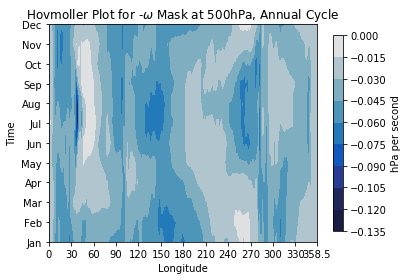

In [12]:
v = np.min(monthly_means_up)
normUp = mpl.colors.Normalize(vmin=v, vmax=-v)
up = plt.contourf(monthly_means_up, cmap=colormap, norm=normUp)
cbar = plt.colorbar(up, shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(mon_list, labels=mon_labels)
plt.ylabel('Time')

plt.title('Hovmoller Plot for -$\omega$ Mask at 500hPa, Annual Cycle')
#plt.savefig('hovmollerUp_annualCycle.png', format='png')

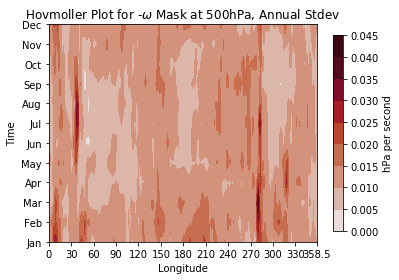

In [23]:
v_stdev = np.max(monthly_stdev_up)
stdUp = mpl.colors.Normalize(vmin=-v_stdev, vmax=v_stdev)
std_up = plt.contourf(monthly_stdev_up, cmap=colormap, norm=stdUp)
cbar = plt.colorbar(std_up, shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(mon_list, labels=mon_labels)
plt.ylabel('Time')

plt.title('Hovmoller Plot for -$\omega$ Mask at 500hPa, Annual Stdev')
#plt.savefig('hovmollerUp_annualStdev.png', format='png')

Text(0.5, 1.0, 'Hovmoller Plot for $\\omega$ Mask at 500hPa, Annual Cycle')

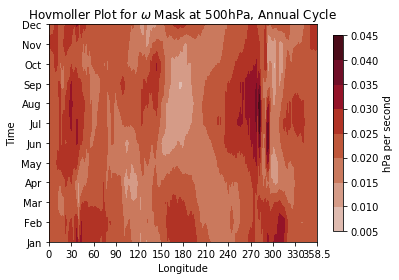

In [20]:
vd = np.max(monthly_means_down)
normD = mpl.colors.Normalize(vmin=-vd, vmax=vd)
down = plt.contourf(monthly_means_down, cmap=colormap, norm=normD)
cbar = plt.colorbar(down, shrink = 0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(mon_list, labels=mon_labels)
plt.ylabel('Time')

plt.title('Hovmoller Plot for $\omega$ Mask at 500hPa, Annual Cycle')
#plt.savefig('hovmollerDown_annualCycle.png', format='png')

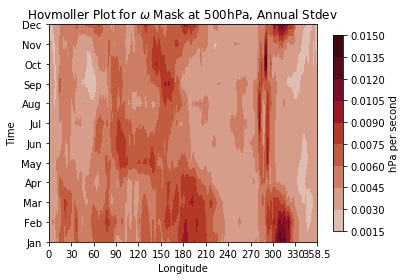

In [24]:
vd_stdev = np.max(monthly_stdev_down)
stdDown = mpl.colors.Normalize(vmin=-vd_stdev, vmax=vd_stdev)
std_down = plt.contourf(monthly_stdev_down, cmap=colormap, norm=stdDown)
cbar = plt.colorbar(std_down, shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(mon_list, labels=mon_labels)
plt.ylabel('Time')

plt.title('Hovmoller Plot for $\omega$ Mask at 500hPa, Annual Stdev')
#plt.savefig('hovmollerDown_annualStdev.png', format='png')

In [29]:
#replace nan values with 0
mask_var_nanmean_up[np.where(np.isnan(mask_var_nanmean_up))] = 0
mask_var_nanmean_down[np.where(np.isnan(mask_var_nanmean_down))] = 0

#normalize omega data, subtract monthly means
norm_up = copy.deepcopy(mask_var_nanmean_up)
norm_d = copy.deepcopy(mask_var_nanmean_down)
count = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count-1].month - 1
        #print(i, j, time[count-1].month, month, count)
        #norm_up[count-1] will have shape(240)
        norm_up[count-1] = norm_up[count-1] - monthly_means_up[month]
        norm_d[count-1] = norm_d[count-1] - monthly_means_down[month]
        count = count + 1

Text(0.5, 1.0, 'Hovmoller Plot for -$\\omega$ Mask at 500hPa')

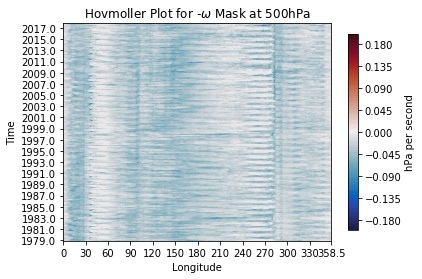

In [39]:
Norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
contour = plt.contourf(mask_var_nanmean_up, contours, cmap=colormap, norm=Norm)
cbar = plt.colorbar(shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for -$\omega$ Mask at 500hPa')
#plt.savefig('hovmollerUp_preRemoval.png', format='png')
#plt.show()

Text(0.5, 1.0, 'Hovmoller Plot for $\\omega$ Mask at 500hPa')

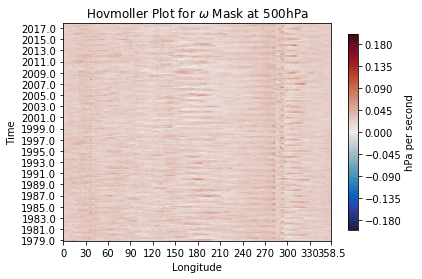

In [40]:
contour = plt.contourf(mask_var_nanmean_down, contours, cmap=colormap, norm=Norm)
cbar = plt.colorbar(shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for $\omega$ Mask at 500hPa')
#plt.savefig('hovmollerDown_preRemoval.png', format='png')
#plt.show()

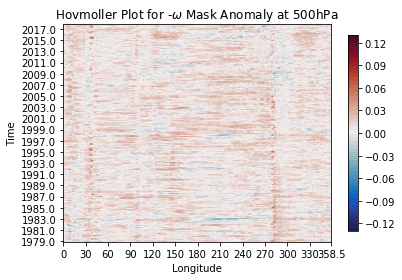

In [63]:
Norm2 = mpl.colors.Normalize(vmin=vmin_diff, vmax=vmax_diff)
contour2 = plt.contourf(norm_up, contours_diff, cmap=colormap, norm=Norm2)
cbar2 = plt.colorbar(shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for -$\omega$ Mask Anomaly at 500hPa')
#plt.savefig('hovmollerUp_cycleRemoved.png', format='png')
#plt.show()

In [53]:
print(np.max(norm_up))
print(np.min(norm_up))

print(np.max(norm_d))
print(np.min(norm_d))

print(np.mean(norm_up))

0.07072735108193084
-0.13044807353810628
0.05149814428531888
-0.029495643016092213
0.00012565924690515965


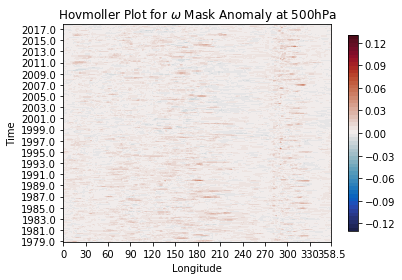

In [62]:
contour2 = plt.contourf(norm_d, contours_diff, cmap=colormap, norm=Norm2)
cbar2 = plt.colorbar(shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for $\omega$ Mask Anomaly at 500hPa')
#plt.savefig('hovmollerDown_cycleRemoved.png', format='png')
#plt.show()

Text(0.5, 1.0, 'Hovmoller Plot for -$\\omega$ Mask at 500hPa')

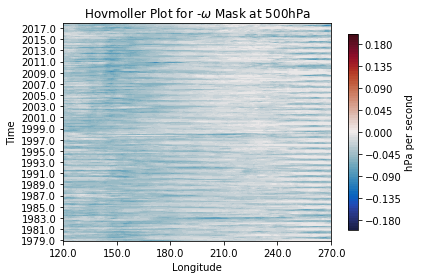

In [43]:
contour2 = plt.contourf(mask_var_nanmean_up[:, 80:181], contours, cmap=colormap, norm=Norm)
cbar2 = plt.colorbar(shrink=0.9)
cbar2.set_label('hPa per second')

plt.xticks([0, 20, 40, 60, 80, 100], labels=lon_list_labels_small)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for -$\omega$ Mask at 500hPa')
#plt.savefig('hovmollerUp_preRemoval_pacific.png', format='png')
#plt.show()

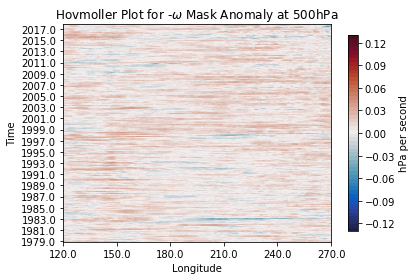

In [64]:
contour2 = plt.contourf(norm_up[:, 80:181], contours_diff, cmap=colormap, norm=Norm2)
cbar2 = plt.colorbar(shrink=0.9)
cbar2.set_label('hPa per second')

plt.xticks([0, 20, 40, 60, 80, 100], labels=lon_list_labels_small)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for -$\omega$ Mask Anomaly at 500hPa')
#plt.savefig('hovmollerUp_cycleRemoved_pacific.png', format='png')
#plt.show()

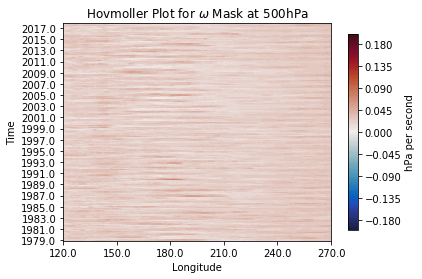

In [61]:
contour2 = plt.contourf(mask_var_nanmean_down[:, 80:181], contours, cmap=colormap, norm=Norm)
cbar2 = plt.colorbar(shrink=0.9)
cbar2.set_label('hPa per second')

plt.xticks([0, 20, 40, 60, 80, 100], labels=lon_list_labels_small)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for $\omega$ Mask at 500hPa')
#plt.savefig('hovmollerDown_preRemoval_pacific.png', format='png')
#plt.show()

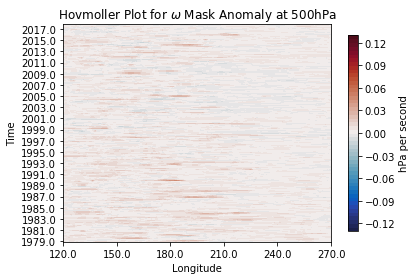

In [60]:
contour2 = plt.contourf(norm_d[:, 80:181], contours_diff, cmap=colormap, norm=Norm2)
cbar2 = plt.colorbar(shrink=0.9)
cbar2.set_label('hPa per second')

plt.xticks([0, 20, 40, 60, 80, 100], labels=lon_list_labels_small)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time')

#plt.axhline(y = 37, color='g')
plt.title('Hovmoller Plot for $\omega$ Mask Anomaly at 500hPa')
#plt.savefig('hovmollerDown_cycleRemoved_pacific.png', format='png')
#plt.show()